# Exploring molecular generative models checking out their latent spaces

Here you can find some examples on how to explore the latent spaces of some of the molecular generative models hosted in GT4SD.

In [1]:
import torch
import mols2grid
import seaborn as sns
from tqdm import tqdm
from rdkit import Chem
from typing import Optional, List
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from paccmann_generator.drug_evaluators.scsore import SCScore


def render_latent_points(latent_points: torch.Tensor, values: Optional[List]):
    decomposed_points = PCA(n_components=2).fit_transform(latent_points)
    sns.scatterplot(x=decomposed_points[:, 0], y=decomposed_points[:, 1], hue=values)


## PolymerBlocks

An algorithm for generating monomers and catalyst for polymer chemistry.

In [2]:
from gt4sd.algorithms.generation.polymer_blocks.core import PolymerBlocksGenerator, PolymerBlocks

configuration = PolymerBlocksGenerator()
algorithm = PolymerBlocks(configuration=configuration)

Using TensorFlow backend.


19:55:04   using as local cache path: /Users/tte/.gt4sd
19:55:04   Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex .
19:55:05   runnning PolymerBlocks with configuration=PolymerBlocksGenerator(algorithm_version='v0', batch_size=32, generated_length=100)
19:55:05   ensure artifacts for the application are present.
19:55:05   starting syncing
19:55:05   syncing complete


Via the algorithm you can easily inspect the generated molecules interactively:

In [3]:
molecules = list(algorithm.sample(15))

In [4]:
mols2grid.display([Chem.MolFromSmiles(molecule) for molecule in molecules], fixedBondLength=200)

To unpack the model and inspect its latent spaces we can simply conduct an exploration using a random point cloud

In [5]:
# get the actual generator
generator = configuration.get_conditional_generator(configuration.ensure_artifacts())
# generate randomly points in the latent space
number_of_latent_points = 1024
latent_points = torch.randn(
    number_of_latent_points - (number_of_latent_points % generator.batch_size),  # making sure the points are chunked properly
    generator.gru_decoder.latent_dim,
    device=generator.device
)
# keep points related to valid molecules
molecules = []
for latent_points_batch in tqdm(torch.split(latent_points, generator.batch_size)):
    indexes = generator.decode(latent_points_batch)
    generated_molecules = [
        Chem.MolFromSmiles(generator.smiles_language.token_indexes_to_smiles(index))
        for index in indexes
    ]
    molecules.extend(generated_molecules)
valid_indexes = [index for index, molecule in enumerate(molecules) if molecule is not None]
molecules = [molecules[index] for index in valid_indexes]
latent_points = latent_points[valid_indexes]

19:55:11   starting syncing
19:55:11   syncing complete


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:22<00:00,  1.44it/s]


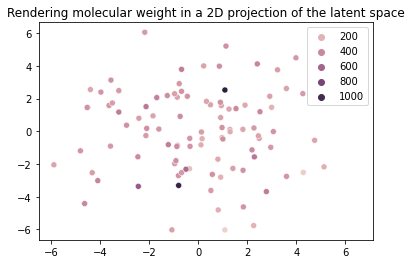

In [6]:
%matplotlib inline
values = [Chem.Descriptors.MolWt(molecule) for molecule in molecules]
_ = render_latent_points(latent_points, values=values)
_ = plt.title("Rendering molecular weight in a 2D projection of the latent space")

## PaccMannRL

A family of algorithms for generating candidate hit-like molecules either targeting an omic profile [[1]](https://doi.org/10.1016/j.isci.2021.102269) or AA sequences [[2]](https://doi.org/10.1088/2632-2153/abe808).

Let's explore the model for targeted ligand design given a protein sequence.

In [7]:
from gt4sd.algorithms.conditional_generation.paccmann_rl.core import PaccMannRL, PaccMannRLProteinBasedGenerator

# >sp|Q9BYF1|ACE2_HUMAN Angiotensin-converting enzyme 2 OS=Homo sapiens OX=9606 GN=ACE2 PE=1 SV=2
target = "".join(filter(str.isalpha, (list("""
MSSSSWLLLSLVAVTAAQSTIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQ
NMNNAGDKWSAFLKEQSTLAQMYPLQEIQNLTVKLQLQALQQNGSSVLSEDKSKRLNTIL
NTMSTIYSTGKVCNPDNPQECLLLEPGLNEIMANSLDYNERLWAWESWRSEVGKQLRPLY
EEYVVLKNEMARANHYEDYGDYWRGDYEVNGVDGYDYSRGQLIEDVEHTFEEIKPLYEHL
HAYVRAKLMNAYPSYISPIGCLPAHLLGDMWGRFWTNLYSLTVPFGQKPNIDVTDAMVDQ
AWDAQRIFKEAEKFFVSVGLPNMTQGFWENSMLTDPGNVQKAVCHPTAWDLGKGDFRILM
CTKVTMDDFLTAHHEMGHIQYDMAYAAQPFLLRNGANEGFHEAVGEIMSLSAATPKHLKS
IGLLSPDFQEDNETEINFLLKQALTIVGTLPFTYMLEKWRWMVFKGEIPKDQWMKKWWEM
KREIVGVVEPVPHDETYCDPASLFHVSNDYSFIRYYTRTLYQFQFQEALCQAAKHEGPLH
KCDISNSTEAGQKLFNMLRLGKSEPWTLALENVVGAKNMNVRPLLNYFEPLFTWLKDQNK
NSFVGWSTDWSPYADQSIKVRISLKSALGDKAYEWNDNEMYLFRSSVAYAMRQYFLKVKN
QMILFGEEDVRVANLKPRISFNFFVTAPKNVSDIIPRTEVEKAIRMSRSRINDAFRLNDN
SLEFLGIQPTLGPPNQPPVSIWLIVFGVVMGVIVVGIVILIFTGIRDRKKKNKARSGENP
YASIDISKGENNPGFQNTDDVQTSF
"""))))
configuration = PaccMannRLProteinBasedGenerator()
algorithm = PaccMannRL(configuration=configuration, target=target)

19:55:34   runnning PaccMannRL with configuration=PaccMannRLProteinBasedGenerator(algorithm_version='v0', batch_size=32, temperature=1.4, generated_length=100)
19:55:34   ensure artifacts for the application are present.
19:55:34   starting syncing
19:55:34   syncing complete
19:55:36   loading configuration file https://s3.amazonaws.com/songlabdata/proteindata/pytorch-models/bert-base-config.json from cache at /Users/tte/.cache/torch/protein_models/fbb05edff0ffa844a729a04850272a1f8973bc002526f6615ad113a5f5aacd36.05edb4ed225e1907a3878f9d68b275d79e025b667555aa94a086e27cb5c591e0
19:55:36   Model config {
  "attention_probs_dropout_prob": 0.1,
  "base_model": "transformer",
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "input_size": 768,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 8192,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": -1,


Via the algorithm you can easily inspect the generated molecules interactively:

In [8]:
molecules = list(algorithm.sample(15))

19:55:38   embedding condition and getting reparametrized latent samples
19:55:41   starting generation of molecules
19:55:42   embedding condition and getting reparametrized latent samples
19:55:45   starting generation of molecules
19:55:46   embedding condition and getting reparametrized latent samples
19:55:49   starting generation of molecules


In [9]:
mols2grid.display([Chem.MolFromSmiles(molecule) for molecule in molecules], fixedBondLength=200)

To unpack the model and inspect its latent spaces we can simply conduct an exploration using a random point cloud

In [10]:
# get the actual generator
generator = configuration.get_conditional_generator(configuration.ensure_artifacts())
# generate randomly points in the latent space
number_of_latent_points = 512
latent_points = torch.randn(
    number_of_latent_points, generator.encoder_latent_size, device=generator.device
)
# keep points related to valid molecules
molecules = []
for latent_point in tqdm(torch.unsqueeze(latent_points, 1)):
    smiles_list = generator.get_smiles_from_latent(latent_point)
    generated_molecules = [
        Chem.MolFromSmiles(smiles)
        for smiles in smiles_list
    ][:1]  # keeping only a molecule per point
    molecules.extend(generated_molecules)
valid_indexes = [index for index, molecule in enumerate(molecules) if molecule is not None]
molecules = [molecules[index] for index in valid_indexes]
latent_points = latent_points[valid_indexes]

19:55:50   starting syncing
19:55:51   syncing complete
19:55:51   loading configuration file https://s3.amazonaws.com/songlabdata/proteindata/pytorch-models/bert-base-config.json from cache at /Users/tte/.cache/torch/protein_models/fbb05edff0ffa844a729a04850272a1f8973bc002526f6615ad113a5f5aacd36.05edb4ed225e1907a3878f9d68b275d79e025b667555aa94a086e27cb5c591e0
19:55:51   Model config {
  "attention_probs_dropout_prob": 0.1,
  "base_model": "transformer",
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "input_size": 768,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 8192,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": -1,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_size": 768,
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 1,
  "vocab_size": 30
}

19:55:52   loading weights file https://s3.a

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:56<00:00,  9.01it/s]


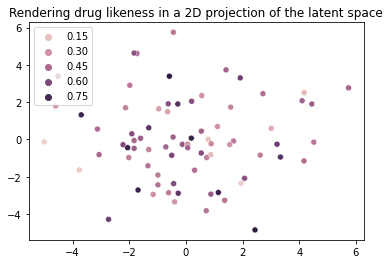

In [11]:
%matplotlib inline
values=[]
for molecule in molecules:
    try:
        values.append(Chem.QED.qed(molecule))
    except:
        values.append(0.0)
_ = render_latent_points(latent_points, values=values)
_ = plt.title("Rendering drug likeness in a 2D projection of the latent space")

## PaccMannGP

An algorithm for generating molecules using controlled sampling based on Gaussian Processes [[3]](https://doi.org/10.1021/acs.jcim.1c00889).

In [12]:
from gt4sd.algorithms.controlled_sampling.paccmann_gp.core import PaccMannGP, PaccMannGPGenerator

# maximizing drug likeness and synthesizability
target = {"qed": {"weight": 1.0}, "sa": {"weight": 1.0}}
configuration = PaccMannGPGenerator()
algorithm = PaccMannGP(configuration=configuration, target=target)

19:56:51   runnning PaccMannGP with configuration=PaccMannGPGenerator(algorithm_version='v0', batch_size=32, temperature=1.4, generated_length=100, limit=5.0, acquisition_function='EI', number_of_steps=32, number_of_initial_points=16, initial_point_generator='random', seed=42, number_of_optimization_rounds=1, sampling_variance=0.1, samples_for_evaluation=4, maximum_number_of_sampling_steps=32)
19:56:51   ensure artifacts for the application are present.
19:56:51   starting syncing
19:56:51   syncing complete


Via the algorithm you can easily inspect the generated molecules interactively:

In [13]:
molecules = list(algorithm.sample(15))

19:56:52   configuring optimization for target: {'qed': {'weight': 1.0}, 'sa': {'weight': 1.0}}
19:56:53   running optimization with the following parameters: {'dimensions': [(-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0), (-5.0,

2022-05-12 19:57:09.224 | WARNING  | paccmann_gp.sa_minimization:evaluate:47 - SA calculation failed.
2022-05-12 19:57:29.235 | WARNING  | paccmann_gp.sa_minimization:evaluate:47 - SA calculation failed.


19:58:13   starting sampling for 1
19:58:58   completing round 1
19:58:58   generated 157 molecules in the current run


In [14]:
mols2grid.display([Chem.MolFromSmiles(molecule) for molecule in molecules], fixedBondLength=200)

To unpack the model and inspect its latent spaces we can simply conduct an exploration using a random point cloud

In [15]:
# get the actual generator
generator = configuration.get_conditional_generator(configuration.ensure_artifacts())
# generate randomly points in the latent space
number_of_latent_points = 1024
latent_points = torch.randn(
    number_of_latent_points - (number_of_latent_points % generator.batch_size),
    generator.latent_dim, device=generator.device
)
# keep points related to valid molecules
molecules = []
for latent_points_batch in tqdm(torch.split(latent_points, generator.batch_size)):
    smiles_list = generator.smiles_generator.generate_smiles(latent_points_batch.unsqueeze(0))
    generated_molecules = [
        Chem.MolFromSmiles(smiles)
        for smiles in smiles_list
    ]
    molecules.extend(generated_molecules)
valid_indexes = [index for index, molecule in enumerate(molecules) if molecule is not None]
molecules = [molecules[index] for index in valid_indexes]
latent_points = latent_points[valid_indexes]

19:58:58   starting syncing
19:58:59   syncing complete


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:45<00:00,  1.43s/it]


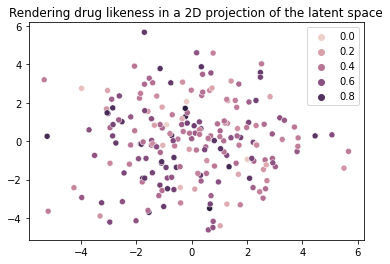

In [16]:
%matplotlib inline
values=[]
for molecule in molecules:
    try:
        values.append(Chem.QED.qed(molecule))
    except:
        values.append(0.0)
_ = render_latent_points(latent_points, values=values)
_ = plt.title("Rendering drug likeness in a 2D projection of the latent space")

## AdvancedManufacturing

A collection of algorithm for generating molecules using controlled sampling leveraging data-driven continuos representations of molecules [[4]](https://doi.org/10.1021/acscentsci.7b00572) extending the autoencoders architecture considered (e.g., VAE-RNNs, VAE-Transformers).

In [17]:
from gt4sd.algorithms.controlled_sampling.advanced_manufacturing.core import AdvancedManufacturing, CatalystGenerator 

# generate catalysts with target binding energy
target = 10.0
configuration = CatalystGenerator()
algorithm = AdvancedManufacturing(configuration=configuration, target=target)

19:59:47   no parameters validation
19:59:47   runnning AdvancedManufacturing with configuration=CatalystGenerator(algorithm_version='v0', number_of_points=32, number_of_steps=50, generated_length=100, primer_smiles='')
19:59:47   ensure artifacts for the application are present.
19:59:47   starting syncing
19:59:48   syncing complete
19:59:48   load vocab from: /Users/tte/.gt4sd/algorithms/controlled_sampling/AdvancedManufacturing/CatalystGenerator/v0/vocab_combined.csv
19:59:48   load vocab from: /Users/tte/.gt4sd/algorithms/controlled_sampling/AdvancedManufacturing/CatalystGenerator/v0/vocab_combined.csv


Via the algorithm you can easily inspect the generated molecules interactively:

In [23]:
molecules = list(algorithm.sample(15))

In [24]:
mols2grid.display([Chem.MolFromSmiles(molecule) for molecule in molecules], fixedBondLength=200)

To unpack the model and inspect its latent spaces we can simply conduct an exploration using a random point cloud

In [20]:
generator = configuration.get_conditional_generator(configuration.ensure_artifacts())

20:01:33   starting syncing
20:01:33   syncing complete
20:01:33   load vocab from: /Users/tte/.gt4sd/algorithms/controlled_sampling/AdvancedManufacturing/CatalystGenerator/v0/vocab_combined.csv
20:01:34   load vocab from: /Users/tte/.gt4sd/algorithms/controlled_sampling/AdvancedManufacturing/CatalystGenerator/v0/vocab_combined.csv


In [21]:
# get the actual generator
generator = configuration.get_conditional_generator(configuration.ensure_artifacts())
# generate randomly points in the latent space
number_of_latent_points = 256
latent_points = torch.randn(number_of_latent_points, generator.vae.z_dimension)
# keep points related to valid molecules
molecules = []
for latent_point in tqdm(latent_points):
    molecules.append(Chem.MolFromSmiles(generator.vae.decode(latent_point)))
valid_indexes = [index for index, molecule in enumerate(molecules) if molecule is not None]
molecules = [molecules[index] for index in valid_indexes]
latent_points = latent_points[valid_indexes]

20:01:34   starting syncing
20:01:34   syncing complete
20:01:34   load vocab from: /Users/tte/.gt4sd/algorithms/controlled_sampling/AdvancedManufacturing/CatalystGenerator/v0/vocab_combined.csv
20:01:34   load vocab from: /Users/tte/.gt4sd/algorithms/controlled_sampling/AdvancedManufacturing/CatalystGenerator/v0/vocab_combined.csv


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:19<00:00, 12.87it/s]


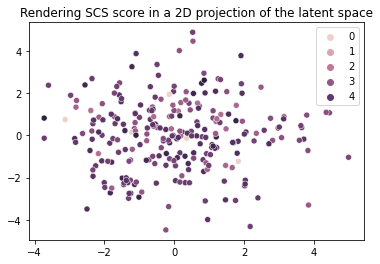

In [22]:
%matplotlib inline
scs_scorer = SCScore()
values = [scs_scorer(molecule) for molecule in molecules]
_ = render_latent_points(latent_points, values=values)
_ = plt.title("Rendering SCS score in a 2D projection of the latent space")